# Data Wrangling

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
import os
import pandas as pd

dataset = "tarun.csv"

if os.path.isfile(dataset):
    df = pd.read_csv("tarun.csv")
else:
    url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)
display(df.head(10))

,Unnamed: 0,0,1,2
0,2698442,2,An Amalgam,This book is an amalgam of bits and pieces and...
1,2646715,5,Great!!!,"Well, not much to say. If you saw the first se..."
2,2119569,2,Hit&Miss,Babyface in his hey day always had a Cut that ...
3,816322,5,Great Buy,This text is considered The Bible for any poli...
4,1476562,3,What time is it anyway?,I thought the other reviews weren't serious ab...
5,17087,3,PRETTY FUNNY,"GOOD,BUT UNREALISTIC.THE GUY JUST QUIT GOING T..."
6,1838666,5,Lacy J. Dalton,I saw Lacy on Bill Anderson's Country Reunion ...
7,1442704,4,Great,Easy and enjoyable to watch. I would recommend...
8,1114640,3,Be careful!!!!,I am a very advanced exerciser and have used t...
9,1308335,5,the best book in the world!!!,Sahara special is one of the best books I have...


In [3]:
df = df.drop('Unnamed: 0',axis=1)

In [4]:
df.columns=['overall','title','reviewText']

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     750000 non-null  int64 
 1   title       749983 non-null  object
 2   reviewText  750000 non-null  object
dtypes: int64(1), object(2)
memory usage: 17.2+ MB
None


The unixReviewTime is converted from Unix time to the more intuitive datetime datatype.

In [6]:
print(df["reviewText"].iloc[0])

This book is an amalgam of bits and pieces and techniques and strategies from other books about creative thinking on the market. If the reader has read very little in the field, then this book might at least be a start.


Each review is associated with a rating stored under the overall field. This serves as the quantified summary of a given review and will thus be used as the ground truth labels for the model.

In [7]:
print(df.overall.unique())

[2 5 3 4 1]


# NLP Pre-Processing

In [8]:
sample_review = df["reviewText"].iloc[749999]
print(sample_review)

I have been searching and searching for a good litter box. I Have been through so many and have wasted so much money. When I got this, our smaller and younger cat was all for it. She used it immediately. Our bigger, older kitty was hesitant. I kept an eye on him and now he is using it! There is no mess and it's so much easier to clean! I highly recommend it!!!!


# HTML Entities

Some special characters like the apostrophe (’) and the en dash (–) are expressed as a set of numbers prefixed by &# and suffixed by ;. This is because the dataset was scraped from an HTML parser, and the dataset itself includes data that predated the universal UTF-8 standard.

These HTML Entities can be decoded by importing the html library.

In [9]:
import html

decoded_review = html.unescape(sample_review)
print(decoded_review)

I have been searching and searching for a good litter box. I Have been through so many and have wasted so much money. When I got this, our smaller and younger cat was all for it. She used it immediately. Our bigger, older kitty was hesitant. I kept an eye on him and now he is using it! There is no mess and it's so much easier to clean! I highly recommend it!!!!


Since punctuation marks do not add value in the way we'll perform NLP, all the HTML entities in the review texts can be dropped. The output series preprocessed is our reviewText but without the special characters.

In [10]:
pattern = r"\&\#[0-9]+\;"
df = df.sample(frac=0.01)
df["preprocessed"] = df["reviewText"].str.replace(pat=pattern, repl="", regex=True)

print(df["preprocessed"].iloc[1])

Irving never ceases to amaze me with his ability to tell stories. In WIDOW FOR ONE YEAR, Irving shows his highest talent (charecter developement) and takes it to the highest level. I have never been let down by a John Irving novel.


In [11]:
df

,overall,title,reviewText,preprocessed
296582,5,It's so Easy and Fun!,This book is great! It was much better than I ...,This book is great! It was much better than I ...
383791,4,Irving still reigns,Irving never ceases to amaze me with his abili...,Irving never ceases to amaze me with his abili...
101275,3,"Good, but not 'Fallen'","Normally, I would listen to an album like 'The...","Normally, I would listen to an album like 'The..."
378197,5,Making the world laugh,This viedo is the best christmas present I hav...,This viedo is the best christmas present I hav...
176298,2,so predictable,i wasn't used to this author when i read this ...,i wasn't used to this author when i read this ...
...,...,...,...,...
33625,1,Very Confusing and Not Very Fun,I had to read this for a grade in Literature c...,I had to read this for a grade in Literature c...
84922,2,disappointing,just a transcript of audience questions at a w...,just a transcript of audience questions at a w...
116084,2,OYE!!!,I bought this book simply because I heard exce...,I bought this book simply because I heard exce...
677337,3,does the job but fragile,"the mouse does not feel well constructed, but ...","the mouse does not feel well constructed, but ..."


In [12]:
%%time
import re
import nltk

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

#import nltk resources
#resources = ["wordnet", "stopwords", "punkt", \
 #            "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]
resources = ["wordnet", "stopwords"]
for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

#create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

#apply our functions
df["preprocessed"] = df["preprocessed"].apply(lambda row: lemmatize_doc(row))

print(df["preprocessed"].iloc[1])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Irving never cease to amaze me with his ability to tell story In WIDOW FOR ONE YEAR Irving show his high talent charecter developement and take it to the high level I have never be let down by a John Irving novel
Wall time: 49.5 s


In [13]:
from unicodedata import normalize

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

df["preprocessed"] = df["preprocessed"].apply(remove_accent)

print(df["preprocessed"].iloc[1])

Irving never cease to amaze me with his ability to tell story In WIDOW FOR ONE YEAR Irving show his high talent charecter developement and take it to the high level I have never be let down by a John Irving novel


In [14]:
pattern = r"[^\w\s]"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

Irving never cease to amaze me with his ability to tell story In WIDOW FOR ONE YEAR Irving show his high talent charecter developement and take it to the high level I have never be let down by a John Irving novel


In [15]:
df["preprocessed"] = df["preprocessed"].str.lower()

print(df["preprocessed"].iloc[1])

irving never cease to amaze me with his ability to tell story in widow for one year irving show his high talent charecter developement and take it to the high level i have never be let down by a john irving novel


In [16]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

stop_words = [word.replace("\'", "") for word in stop_words]

print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") \
                                          if token not in stop_words])
df["preprocessed"] = df["preprocessed"].apply(remove_stop_words)

print(df["preprocessed"].iloc[1])

sample stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours'] 

irving never cease amaze ability tell story widow one year irving show high talent charecter developement take high level never let john irving novel


In [17]:
pattern = r"[\s]+"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

irving never cease amaze ability tell story widow one year irving show high talent charecter developement take high level never let john irving novel


In [18]:
corpora = df["preprocessed"].values
tokenized = [corpus.split(" ") for corpus in corpora]

print(tokenized[1])

['irving', 'never', 'cease', 'amaze', 'ability', 'tell', 'story', 'widow', 'one', 'year', 'irving', 'show', 'high', 'talent', 'charecter', 'developement', 'take', 'high', 'level', 'never', 'let', 'john', 'irving', 'novel']


In [19]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=300, threshold=50)

In [20]:
tri_gram

In [21]:
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:50])

['dirge', 'participate', 'thir', 'uncles', 'kniefs', 'chucking', 'compassionately', 'broader', 'xxxlarge', 'revamped', 'dvdlegacy', 'encompass', 'bough', 'sobieski', 'greed', 'alphabet', 'nursing', 'guidea', 'hammered', 'murray', 'perkin', 'alexei', 'tweezer', 'distressing', 'origin', 'dsofil', 'unfortunatequality', 'starr', 'working', 'record', 'counterpoint', 'onboard', 'materialistic', 'goodness', 'masterful', 'nano', 'everyday', 'ddr', 'drunk', 'brits', 'laidback', 'watershed', 'peoples', 'luck', 'myss', 'soundgarden', 'johns', 'diligent', 'scholarship', 'numbered']


In [22]:
bigram_min = bi_gram.min_count

bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set([token.decode("utf-8") \
                      for token in bi_gram_tokens])

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only)[:50])

[]


In [23]:
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set([token.decode("utf-8") \
                       for token in tri_gram_tokens])

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

[]


In [24]:
#tokenized = [Phraser(tri_gram)[Phraser(bi_gram)[i]] for i in tokenized]

In [25]:
tokenized = [list(filter(lambda x: len(x) > 1, document)) \
             for document in tokenized]

print(tokenized[1])

['irving', 'never', 'cease', 'amaze', 'ability', 'tell', 'story', 'widow', 'one', 'year', 'irving', 'show', 'high', 'talent', 'charecter', 'developement', 'take', 'high', 'level', 'never', 'let', 'john', 'irving', 'novel']


In [26]:
len(tokenized)

7500

In [27]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(tokenized)

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: 45
ID: 1, Token: arrange
ID: 2, Token: book
ID: 3, Token: consist
ID: 4, Token: design
ID: 5, Token: entertain
ID: 6, Token: especially
ID: 7, Token: even
ID: 8, Token: expect
ID: 9, Token: figure


In [28]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: 45, Frequency: 1
Word: arrange, Frequency: 1
Word: book, Frequency: 4
Word: consist, Frequency: 1
Word: design, Frequency: 1
Word: entertain, Frequency: 1
Word: especially, Frequency: 1
Word: even, Frequency: 2
Word: expect, Frequency: 2
Word: figure, Frequency: 3
Word: folk, Frequency: 1
Word: freezing, Frequency: 1
Word: get, Frequency: 2
Word: good, Frequency: 1
Word: great, Frequency: 1
Word: guy, Frequency: 1
Word: help, Frequency: 1
Word: husband, Frequency: 1
Word: ingredient, Frequency: 1
Word: kind, Frequency: 1
Word: lady, Frequency: 1
Word: last, Frequency: 1
Word: like, Frequency: 2
Word: meal, Frequency: 2
Word: meat, Frequency: 1
Word: money, Frequency: 1
Word: much, Frequency: 1
Word: need, Frequency: 1
Word: normal, Frequency: 1
Word: order, Frequency: 2
Word: page, Frequency: 1
Word: part, Frequency: 1
Word: potatoes, Frequency: 1
Word: prepare, Frequency: 1
Word: reading, Frequency: 1
Word: recipe, Frequency: 3
Word: rest, Frequency: 1
Word: start, Frequency: 1


In [29]:
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow)

for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: 45, Weight: 0.170
Word: arrange, Weight: 0.191
Word: book, Weight: 0.136
Word: consist, Weight: 0.170
Word: design, Weight: 0.104
Word: entertain, Weight: 0.124
Word: especially, Weight: 0.095
Word: even, Weight: 0.111
Word: expect, Weight: 0.156
Word: figure, Weight: 0.328
Word: folk, Weight: 0.140
Word: freezing, Weight: 0.191
Word: get, Weight: 0.071
Word: good, Weight: 0.034
Word: great, Weight: 0.045
Word: guy, Weight: 0.101
Word: help, Weight: 0.085
Word: husband, Weight: 0.112
Word: ingredient, Weight: 0.152
Word: kind, Weight: 0.092
Word: lady, Weight: 0.139
Word: last, Weight: 0.078
Word: like, Weight: 0.071
Word: meal, Weight: 0.332
Word: meat, Weight: 0.147
Word: money, Weight: 0.074
Word: much, Weight: 0.053
Word: need, Weight: 0.070
Word: normal, Weight: 0.131
Word: order, Weight: 0.167
Word: page, Weight: 0.087
Word: part, Weight: 0.076
Word: potatoes, Weight: 0.233
Word: prepare, Weight: 0.139
Word: reading, Weight: 0.105
Word: recipe, Weight: 0.391
Word: rest, Wei

In [30]:
%%time
import numpy as np

from gensim.models import word2vec

np.set_printoptions(suppress=True)

feature_size = 100
context_size = 20
min_word = 1

word_vec= word2vec.Word2Vec(tokenized, size=feature_size, \
                            window=context_size, min_count=min_word, \
                            iter=50, seed=42)

Wall time: 19.5 s


In [31]:
word_vec_unpack = [(word, idx.index) for word, idx in \
                   word_vec.wv.vocab.items()]

tokens, indexes = zip(*word_vec_unpack)

word_vec_df = pd.DataFrame(word_vec.wv.syn0[indexes, :], index=tokens)

display(word_vec_df)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
book,0.473933,2.031544,0.144914,2.006794,-0.734517,1.674126,2.246942,-0.480431,6.861092,2.264152,...,1.226266,1.322437,-0.411422,-2.821130,2.116461,-1.365416,0.696029,-1.083830,3.029635,0.644920
great,-0.401614,-0.443145,0.961471,2.243196,-1.739263,-2.525467,3.612262,2.453292,0.669934,1.951713,...,2.552096,-0.407293,-0.683475,2.425638,-2.142784,-1.740284,2.142993,-0.114620,1.154964,0.295705
much,1.459514,2.211950,0.357363,1.205409,1.894880,4.310168,2.511547,-0.755443,4.987301,-0.609852,...,-6.128918,-0.246045,1.037766,-2.157252,2.597230,5.104257,-2.244558,-1.697425,-2.117085,2.040644
good,2.312189,1.209942,-1.395000,2.660496,0.063924,0.188568,2.270544,-3.276166,-0.509674,3.783722,...,0.843475,-0.307077,-1.202192,-0.769249,-0.116857,-0.026961,1.173099,0.760099,-1.414798,3.892892
expect,3.170430,-2.143033,-1.712481,0.826510,2.738990,1.255772,2.099599,0.861249,0.415440,3.118057,...,2.056819,2.357683,3.924774,-2.185290,-3.787751,2.187168,0.370274,4.457578,2.951658,2.383199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
savagery,-0.092008,0.253319,0.213418,0.433524,0.115016,0.284407,-0.252505,0.012714,0.295424,0.104680,...,0.454096,0.218229,0.246108,-0.268143,0.021721,-0.277356,0.240709,-0.442672,-0.042527,0.513283
nvc,0.102639,0.035608,-0.079746,0.111624,-0.144803,-0.004030,-0.018794,0.023330,-0.139459,0.088208,...,-0.226816,0.120688,-0.190069,0.088526,0.126409,-0.154034,-0.046966,0.028598,0.141534,-0.185029
fininshed,-0.134379,-0.087544,0.096107,-0.185092,-0.090361,-0.104177,0.096264,-0.201469,0.145153,-0.193640,...,0.061876,0.095644,-0.023005,0.263724,-0.020929,0.154851,-0.033009,-0.110854,-0.000965,-0.141431
___,0.455532,0.475874,-0.077724,0.094422,0.432268,-0.381822,0.187695,-0.647711,0.101507,-0.184832,...,0.527891,0.810940,-0.203330,-0.303546,-0.280099,-0.315587,0.338528,-0.538959,0.016911,0.071101


In [32]:
word_vec_df.count()

0     25107
1     25107
2     25107
3     25107
4     25107
      ...  
95    25107
96    25107
97    25107
98    25107
99    25107
Length: 100, dtype: int64

In [33]:
%%time
tokenized_array = np.array(tokenized)

model_array = np.array([word_vec_df.loc[doc].mean(axis=0) for doc in tokenized_array])

Wall time: 5.46 s


In [34]:
a=df["overall"].reset_index().drop('index',axis=1)

In [35]:
a

,overall
0,5
1,4
2,3
3,5
4,2
...,...
7495,1
7496,2
7497,2
7498,3


In [36]:
model_df = pd.DataFrame(model_array)
model_df["label"] = a

display(model_df.head())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.370055,-0.036244,-0.865032,0.474538,-0.482466,-0.511945,0.354538,-0.180968,1.406547,0.676271,...,0.451979,0.395719,-1.040735,-0.302282,-0.761068,0.289924,0.105268,0.451185,0.157050,5
1,-0.435048,0.712183,0.551567,-1.182198,-1.151477,-0.050194,-1.009265,0.028724,0.123528,1.412482,...,0.227271,0.240064,1.015466,-0.266507,-0.443571,-0.149344,0.193116,-0.299025,-0.233976,4
2,0.064421,0.800211,-0.973759,0.153602,-0.619693,0.764342,1.126256,0.537945,0.270255,1.025812,...,-0.272536,0.211203,0.474835,0.840743,-0.543172,0.100005,0.791048,-0.120424,-0.538677,3
3,-0.524502,0.032123,-0.181932,-0.919244,-0.893136,-0.136069,-0.577038,0.546389,-0.324473,0.464058,...,-0.574750,-0.348195,-0.677840,0.123618,-1.106985,0.044047,0.361500,-0.416618,-0.783229,5
4,0.377644,0.526868,0.285591,-0.179645,-1.172014,0.171150,0.587676,0.322995,0.917117,0.989655,...,-0.549639,0.449902,-0.210657,0.214495,-0.052960,-0.177694,-0.553796,0.775791,0.715011,2


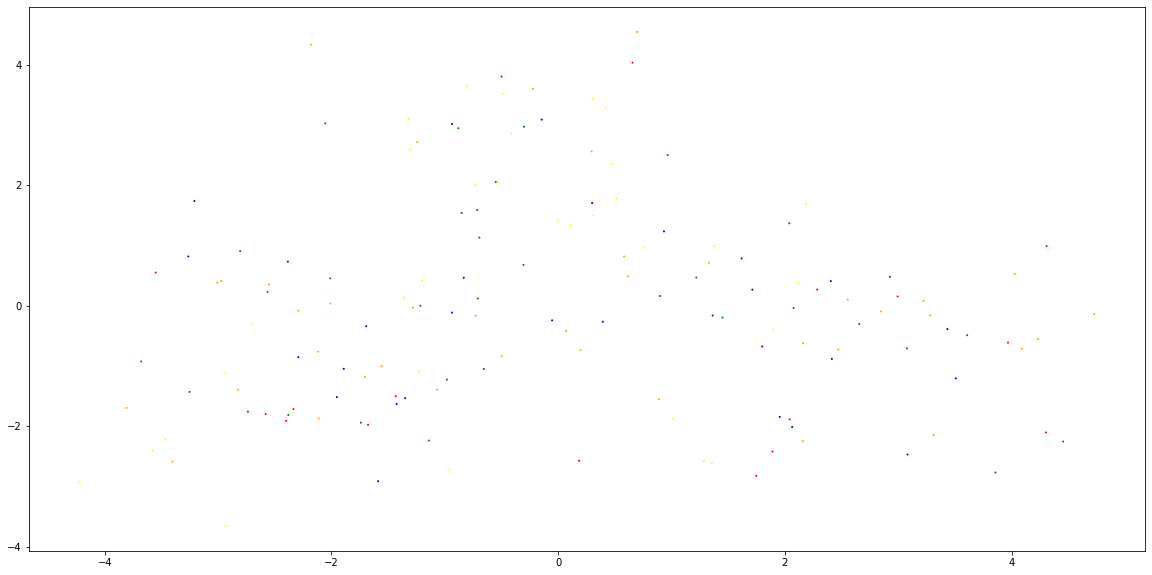

In [37]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#sampling the model_df population
pca_df = model_df.reset_index()
pca_df = model_df.dropna(axis=0).iloc[:,1:]
pca_df = pca_df.iloc[::50]

#setting up PCA
pca = PCA(n_components=2, random_state=42)
pca = pca.fit_transform(pca_df.iloc[:, :-1])
labels = pca_df["label"]

#setting up plot components
x_axis = pca[:,0]
y_axis = pca[:,1]
color_map = pca_df["label"].map({1:"blue", \
                                 2:"red", \
                                 3:"yellow", \
                                 4:"green", \
                                 5:"orange"})

#plotting PCA
f, axes = plt.subplots(figsize=(20,10))
plt.scatter(x_axis, y_axis, color=color_map, s=1)
plt.show()

In [39]:
word_bank = ["book", "phone", "tv", "good", "price"]

for word in word_bank[:]:
    related_vec = word_vec.wv.most_similar(word, topn=5)
    related_words = np.array(related_vec)[:,0]
    word_bank.extend(related_words)
    print(f"{word}: {related_words}")

book: ['read' 'chapter' 'skim' 'author' 'text']
phone: ['cell' 'v3' 'razr' 'caller' 'motorola']
tv: ['channel' 'somethink' 'zim' 'cable' 'trest']
good: ['pretty' 'actually' 'valve' 'improve' 'xxx']
price: ['00' 'shipping' 'cost' '99' 'bargain']


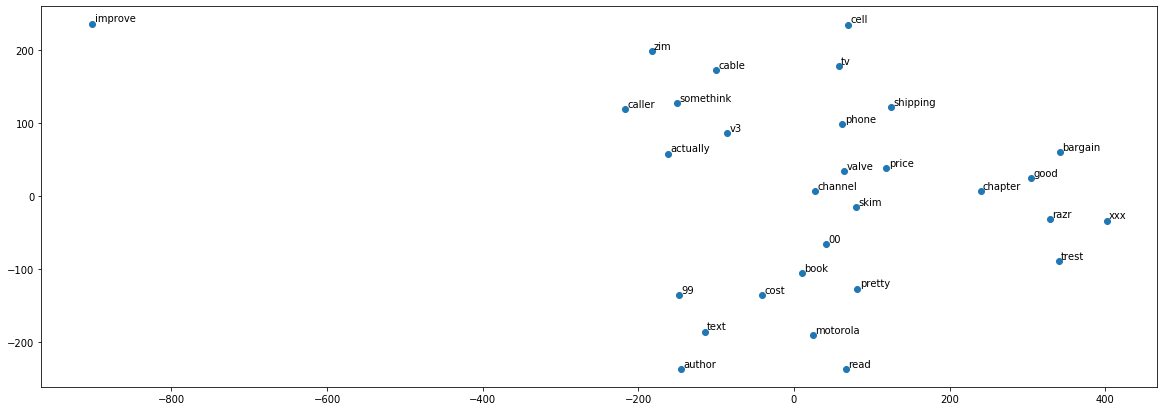

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)

sample_vecs = word_vec.wv[set(word_bank)]
sample_tsne = tsne.fit_transform(sample_vecs)
tsne_x = sample_tsne[:, 0]
tsne_y = sample_tsne[:, 1]

f, axes = plt.subplots(figsize=(20,7))
ax = plt.scatter(x=tsne_x, y=tsne_y)

for label, x, y in zip(word_bank, tsne_x, tsne_y):
    plt.annotate(label, xy=(x+3, y+3))

plt.show()

In [41]:
word_vec.wv.most_similar(positive=["books", "away"], \
                      negative=[], topn=1)

[('corinne', 0.5222021341323853)]

In [42]:
word_vec.wv.most_similar(positive=["cheap"], \
                      negative=["quality"], topn=1)

[('cleanly', 0.3962861895561218)]

In [43]:
word_vec.wv.most_similar(positive=["tablet"], \
                      negative=["phone"], topn=1)

[('viewsonic', 0.445182740688324)]

In [44]:
df["reviewText"].iloc[1000]

"I knew I loved Tone when I first heard Solidarity. Though this album isn't quite as interesting, it is still excellent and has a couple killer tracks."

In [45]:
#helpful = df["helpful"].tolist()
#most_helpful = max(helpful, key=lambda x: x[0])

#most_helpful_idx = df["helpful"].astype(str) == str(most_helpful)
#most_helpful_idx = df[most_helpful_idx].index

most_helpful_text = df["reviewText"].iloc[1000]

print(most_helpful_text)

I knew I loved Tone when I first heard Solidarity. Though this album isn't quite as interesting, it is still excellent and has a couple killer tracks.


In [46]:
%%time
import spacy

from collections import defaultdict

ner = spacy.load('en_core_web_sm')

ner_helpful = ner(most_helpful_text)

ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)

for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

ORDINAL:
[first]

ORG:
[Solidarity]

Wall time: 1.28 s


In [47]:
from spacy import displacy

displacy.render(ner_helpful, style="ent", jupyter=True)

In [48]:
def ner_displacy(sentence):
    ner_sentence = ner(sentence)
    displacy.render(ner_sentence, jupyter=True, \
                    options={"compact": False, \
                             "distance": 90, \
                             "word_spacing":20, \
                             "arrow_spacing":10, \
                             "arrow_stroke": 2, \
                             "arrow_width": 5})

for sentence in most_helpful_text.split(".")[0:3]:
    ner_displacy(sentence)

In [49]:
%%time
import multiprocessing

from gensim.models.ldamulticore import LdaMulticore

cores = multiprocessing.cpu_count()

num_topics = 10
bow_lda = LdaMulticore(bow, num_topics=num_topics, id2word=vocabulary, \
                       passes=5, workers=cores, random_state=42)

for token, frequency in bow_lda.show_topic(0, topn=5):
    print(token, frequency)

movie 0.016420124
get 0.0103220735
one 0.009831821
good 0.008627526
time 0.007250724
Wall time: 16.1 s


In [50]:
for topic in range(0, num_topics):
    print(f"\nTopic {topic+1}:")
    for token, frequency in bow_lda.show_topic(topic, topn=5):
        print(f" {token}, {frequency}")


Topic 1:
 movie, 0.01642012409865856
 get, 0.010322073474526405
 one, 0.009831820614635944
 good, 0.008627526462078094
 time, 0.007250723894685507

Topic 2:
 get, 0.009982112795114517
 like, 0.0067370859906077385
 good, 0.006368828006088734
 one, 0.006335279904305935
 album, 0.006139581557363272

Topic 3:
 like, 0.01434553787112236
 good, 0.01099165715277195
 song, 0.009767410345375538
 cd, 0.008763490244746208
 time, 0.0071853953413665295

Topic 4:
 book, 0.016476260498166084
 good, 0.014703850261867046
 get, 0.011597823351621628
 use, 0.011325066909193993
 one, 0.00811483059078455

Topic 5:
 book, 0.009953271597623825
 great, 0.009741025045514107
 good, 0.007494382560253143
 make, 0.0065760426223278046
 game, 0.006404861342161894

Topic 6:
 one, 0.01719803363084793
 like, 0.008012591861188412
 get, 0.007836416363716125
 use, 0.006866587325930595
 would, 0.006355995777994394

Topic 7:
 book, 0.011698196642100811
 like, 0.011013850569725037
 buy, 0.00911701563745737
 movie, 0.00900023

In [51]:
import pyLDAvis.gensim

lda_idm = pyLDAvis.gensim.prepare(bow_lda, bow, vocabulary)

pyLDAvis.display(lda_idm)

In [52]:
nan_list = model_df[model_df[0].isna()].index
nan_list = nan_list.tolist()

print(nan_list[0:50])

[]


In [53]:
print(*[tokenized[blank] for blank in nan_list[0:5]])

In [54]:
for blank in nan_list[0:5]:
    display(df["reviewText"].iloc[blank])

In [55]:
print(f"Original 'model_df' count: {len(model_df)}")
print(f"Final 'model_df' count: {len(model_df.dropna(axis=0))}")

model_df = model_df.dropna(axis=0)
display(model_df.head())

Original 'model_df' count: 7500
Final 'model_df' count: 7500


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.370055,-0.036244,-0.865032,0.474538,-0.482466,-0.511945,0.354538,-0.180968,1.406547,0.676271,...,0.451979,0.395719,-1.040735,-0.302282,-0.761068,0.289924,0.105268,0.451185,0.157050,5
1,-0.435048,0.712183,0.551567,-1.182198,-1.151477,-0.050194,-1.009265,0.028724,0.123528,1.412482,...,0.227271,0.240064,1.015466,-0.266507,-0.443571,-0.149344,0.193116,-0.299025,-0.233976,4
2,0.064421,0.800211,-0.973759,0.153602,-0.619693,0.764342,1.126256,0.537945,0.270255,1.025812,...,-0.272536,0.211203,0.474835,0.840743,-0.543172,0.100005,0.791048,-0.120424,-0.538677,3
3,-0.524502,0.032123,-0.181932,-0.919244,-0.893136,-0.136069,-0.577038,0.546389,-0.324473,0.464058,...,-0.574750,-0.348195,-0.677840,0.123618,-1.106985,0.044047,0.361500,-0.416618,-0.783229,5
4,0.377644,0.526868,0.285591,-0.179645,-1.172014,0.171150,0.587676,0.322995,0.917117,0.989655,...,-0.549639,0.449902,-0.210657,0.214495,-0.052960,-0.177694,-0.553796,0.775791,0.715011,2


In [56]:
model_df.label.value_counts()

3    1543
5    1501
4    1498
2    1480
1    1478
Name: label, dtype: int64

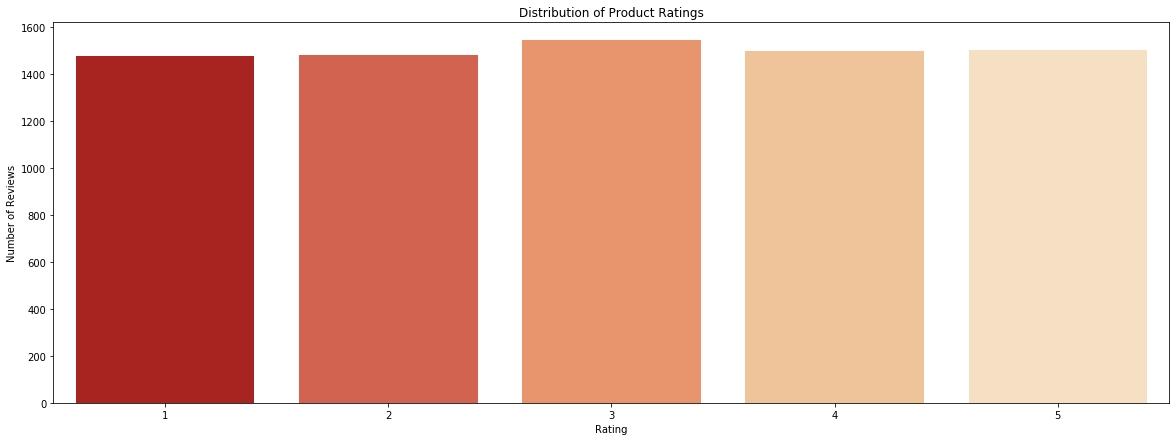

In [57]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["overall"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [58]:
majority = df["overall"] == 5
majority_ratio = len(df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

20.01%


In [59]:
count = len(model_df[model_df["label"] == 2])
print(f"Size of the most underrepresented class: {count}")

Size of the most underrepresented class: 1480


In [60]:
 model_df["label"]

0       5
1       4
2       3
3       5
4       2
       ..
7495    1
7496    2
7497    2
7498    3
7499    5
Name: label, Length: 7500, dtype: int64

In [61]:
condition = model_df["label"] == 5

In [62]:
#trim the majority class
condition = model_df["label"] == 5.0
trimmed_df = model_df[condition].sample(n=count, random_state=42,replace=True)

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    trimmed_df = pd.concat([trimmed_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(trimmed_df[trimmed_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

Size of Class 1: 1478
Size of Class 2: 1480
Size of Class 3: 1480
Size of Class 4: 1480
Size of Class 5: 1480


In [63]:
trimmed_df = trimmed_df.sort_values(by="label")
display(trimmed_df.tail())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
3250,0.314435,0.929919,-1.473633,0.317411,-0.047238,-0.739472,2.433177,-0.143843,-0.390902,0.867095,...,-0.050949,-0.267008,-0.585570,-1.286420,-0.618917,-0.167498,0.987807,0.730315,0.574775,5
1364,0.042079,0.713728,-0.944260,-0.000291,-0.433093,0.318591,-0.444953,-0.881099,0.871503,0.693251,...,0.202934,0.761013,-0.210264,0.748842,-0.742382,-0.117543,-0.320548,0.339892,-0.297017,5
3090,-0.637355,1.415326,-1.004806,-0.055007,-1.080608,0.382729,-0.054993,0.581425,-0.213994,-0.002435,...,-1.607477,-0.539329,-0.398526,-0.374052,-0.339678,0.064820,0.659684,-1.106164,0.375402,5
6648,0.279748,0.090814,-0.105628,-0.581335,-0.823585,-0.433211,-0.413008,0.909068,0.488734,0.557967,...,-1.469867,0.634034,0.089385,-0.476890,-0.545827,-0.853240,-0.685485,0.464088,0.090888,5
5578,0.376858,2.463825,-0.499446,-0.562520,-1.411313,0.036832,-0.293224,-0.545251,1.368005,0.345307,...,0.256804,-0.147865,0.152207,-1.008459,0.234910,0.354489,-1.208386,1.381222,0.683353,5


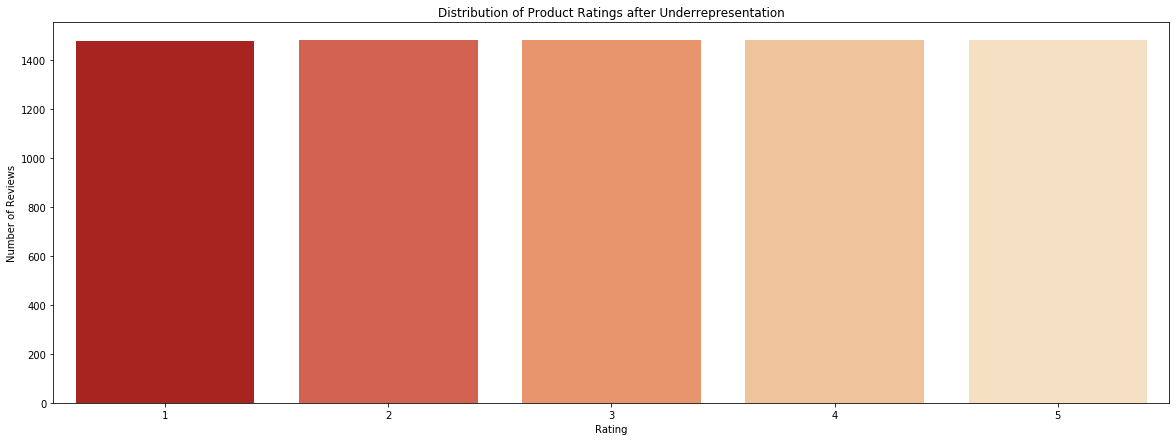

In [64]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=trimmed_df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings after Underrepresentation", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [65]:
from sklearn.model_selection import train_test_split

X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [66]:
from sklearn import metrics

label_shape = np.shape(y_test)
y_baseline = np.full(label_shape, 5)

accuracy_baseline = metrics.accuracy_score(y_test, y_baseline)
f1_score_baseline = metrics.f1_score(y_test, y_baseline, average="micro")

print(f"Baseline Accuracy: {accuracy_baseline*100:.3f}%")
print(f"Baseline F1 Score: {f1_score_baseline:.3f}")

Baseline Accuracy: 20.005%
Baseline F1 Score: 0.200


In [67]:
from sklearn.model_selection import train_test_split

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

In [68]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=2, class_weight={1:10, 2:12, 3:7, 4:9, 5:1}, \
                                criterion="entropy", random_state=42)
forest.fit(X_train,y_train)

Wall time: 292 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={1: 10, 2: 12, 3: 7, 4: 9, 5: 1},
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression()
clr.fit(X_train, y_train.values.ravel())
scores = clr.score(X_train, y_train) # accuracy
print("Logistic Regression : " , scores)

Logistic Regression :  0.449


# SVM

In [70]:
from sklearn import svm
# instantiate and train model, kernel=rbf 
svm_rbf = svm.SVC(random_state=12345)
svm_rbf.fit(X_train, y_train)

# evaulate model
y_pred_1 = svm_rbf.predict(X_train)
print(" SVM : ", y_pred_1)
def eval_predictions(y_train, y_pred):
    print ('accuracy:', metrics.accuracy_score(y_train, y_pred))
    print ('precision:', metrics.precision_score(y_train, y_pred, average='weighted'))
    print ('recall:', metrics.recall_score(y_train, y_pred, average='weighted'))
    print ('F-measure:', metrics.f1_score(y_train, y_pred, average='weighted'))
eval_predictions(y_train, y_pred_1)


 SVM :  [4 3 1 ... 2 5 2]
accuracy: 0.6485
precision: 0.647337290109779
recall: 0.6485
F-measure: 0.6463163810263218


# Navie Bayes

In [75]:
%time
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

Wall time: 0 ns


ValueError: Negative values in data passed to MultinomialNB (input X)

In [91]:
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 63.522%
Training Set F1 Score: 0.635


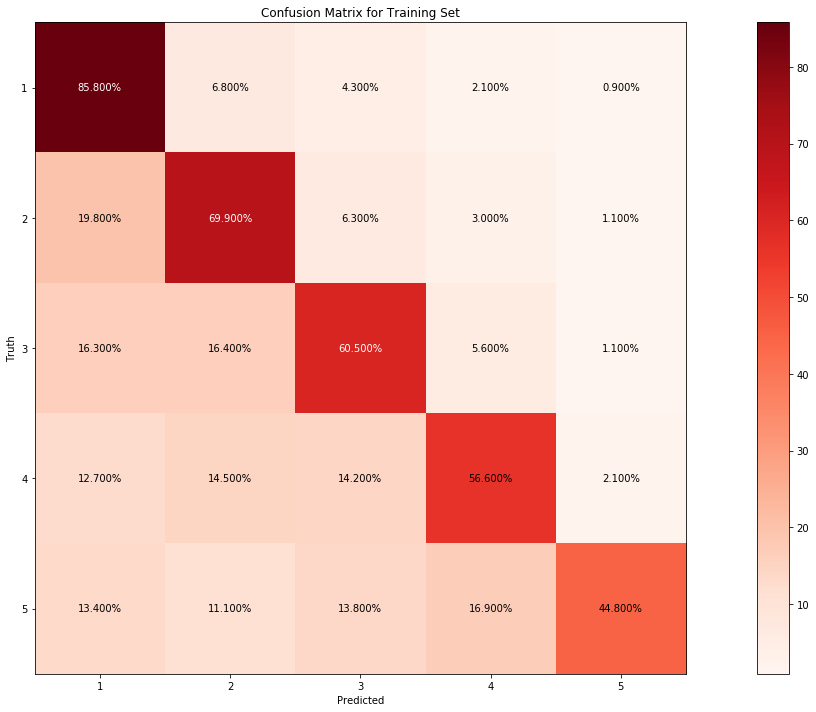

In [92]:
from sklearn.metrics import confusion_matrix

#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [93]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="accuracy")
cross_val_f1 = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="f1_micro")

cross_val_accuracy = np.mean(cross_val_accuracy)
cross_val_f1 = np.mean(cross_val_f1)

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")
print(f"Training Set F1 Score: {cross_val_f1:.3f}")

Training Set Accuracy: 25.333%
Training Set F1 Score: 0.253


In [94]:
%%time
import xgboost as xgb

y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

parameters = {"max_depth": 4, "eta": 0.2, "silent": 1, \
              "objective": "multi:softprob", "num_class": 5}

boost = xgb.train(parameters, train_set, 100)

Wall time: 9.35 s


In [95]:
y_pred = boost.predict(train_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 94.587%
Training Set F1 Score: 0.946


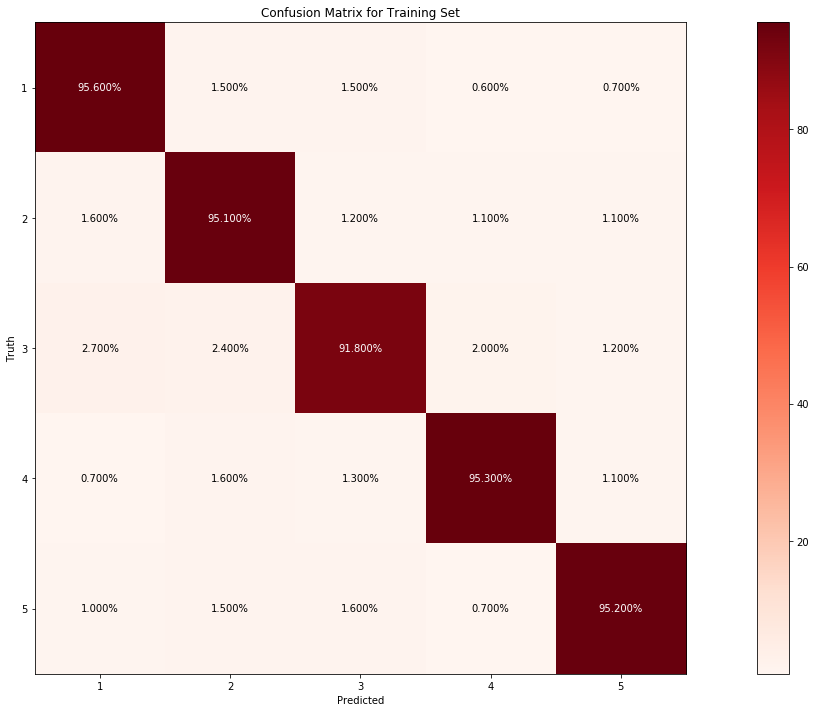

In [96]:
#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [97]:
%%time
boost_cv = xgb.cv(dtrain=train_set, params=parameters, nfold=3, \
                  num_boost_round=50, early_stopping_rounds=10, \
                  metrics="merror", as_pandas=True, seed=42)

display(boost_cv.head())

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.564577,0.006659,0.693930,0.005650
1,0.519701,0.007833,0.692139,0.005897
2,0.483881,0.009903,0.684577,0.008363
3,0.455622,0.008122,0.670846,0.012826
4,0.436119,0.011256,0.663880,0.009339


Wall time: 6.92 s


In [98]:
cross_val_accuracy = boost_cv.iloc[-1,2]
cross_val_accuracy = 1-cross_val_accuracy

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")

Training Set Accuracy: 36.716%


In [99]:
y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

Test Set Accuracy: 38.828%
Test Set F1 Score: 0.388


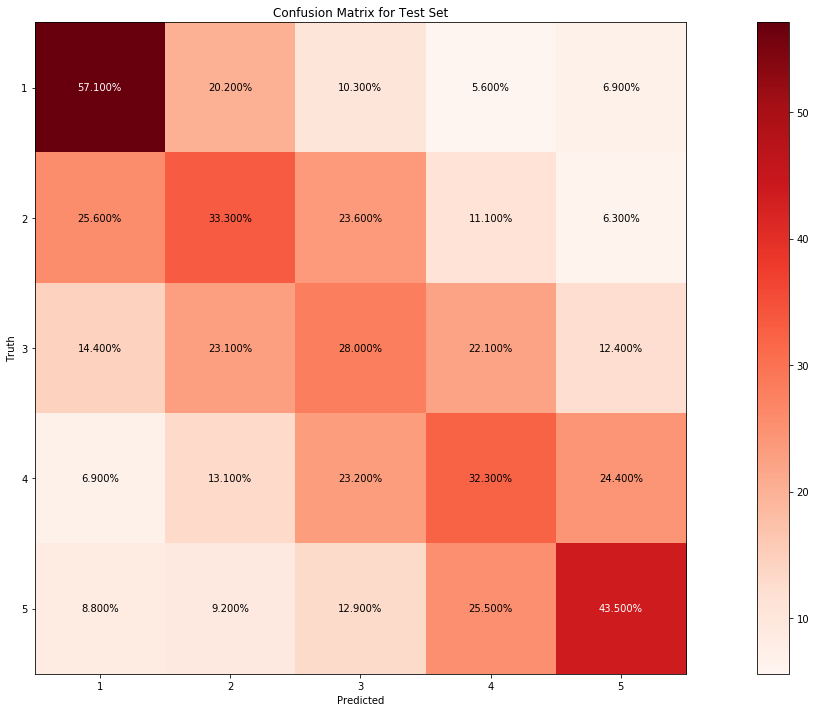

In [100]:
#create the confusion matrix of the test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [101]:
X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [102]:
y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Balanced Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Balanced Test Set F1 Score: {f1_score:.3f}")

Balanced Test Set Accuracy: 76.507%
Balanced Test Set F1 Score: 0.765


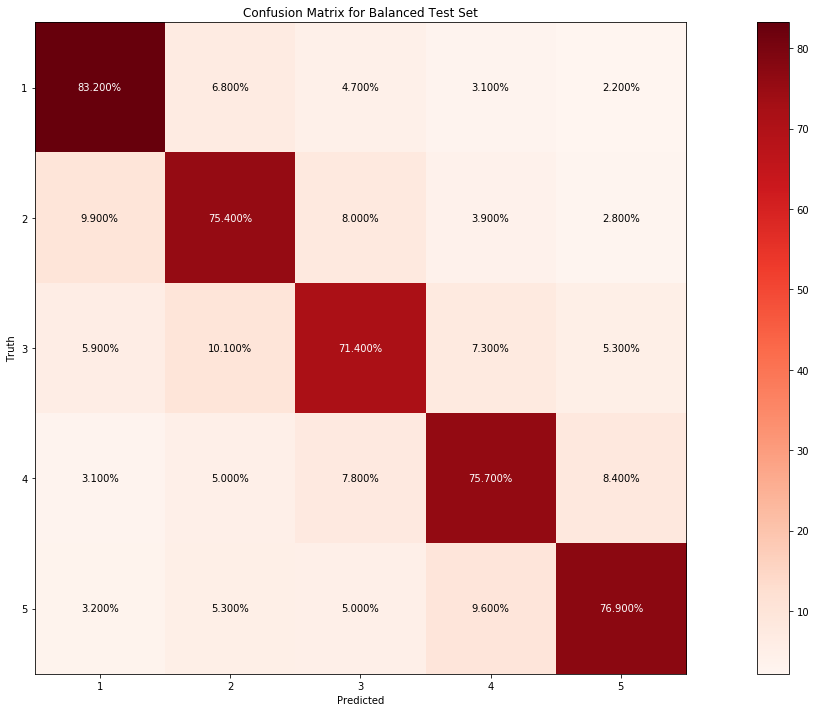

In [103]:
#create the confusion matrix of the balanced test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Balanced Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

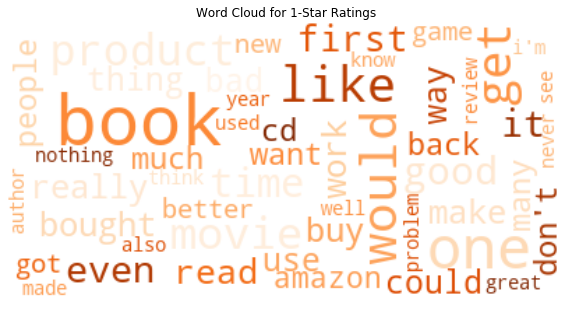

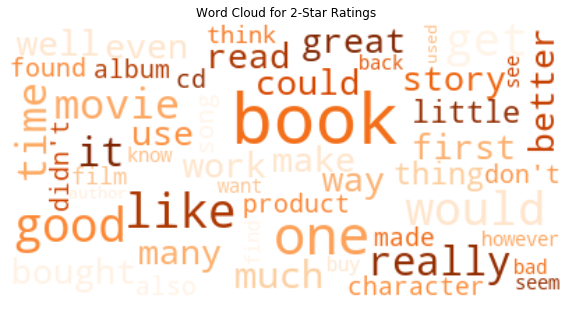

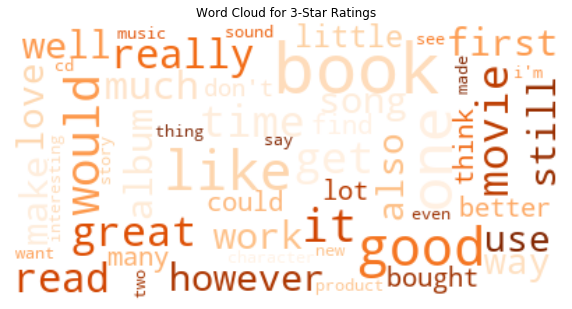

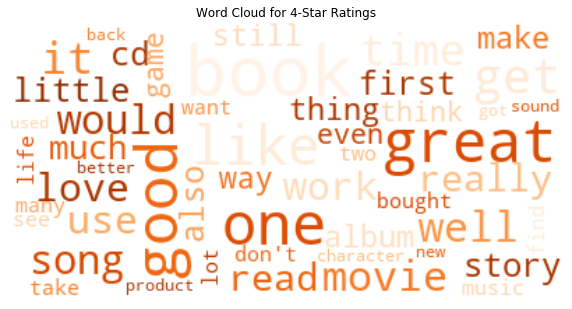

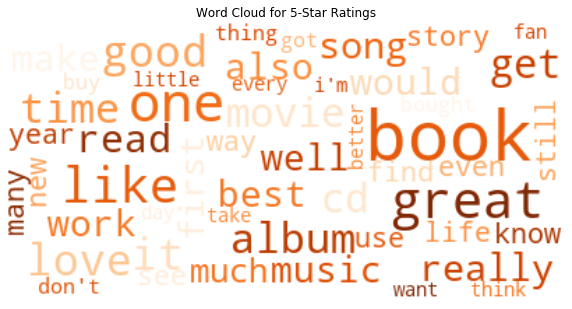

In [104]:
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = set(stop_words), min_font_size=10, \
                      max_font_size=50, max_words=50, \
                      background_color="white", colormap = "Oranges")

one_star_text = " ".join(df[df["overall"]==1]["reviewText"].values).lower()
two_star_text = " ".join(df[df["overall"]==2]["reviewText"].values).lower()
three_star_text = " ".join(df[df["overall"]==3]["reviewText"].values).lower()
four_star_text = " ".join(df[df["overall"]==4]["reviewText"].values).lower()
five_star_text = " ".join(df[df["overall"]==5]["reviewText"].values).lower()

text_list = [one_star_text, two_star_text, three_star_text, \
             four_star_text, five_star_text]

for index, text in enumerate(text_list):
    f, axes = plt.subplots(figsize=(10,7))
    wordcloud.generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {index+1}-Star Ratings")
    plt.axis("off")
    plt.show()

In [105]:
df['overall'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

In [106]:
df['overall'].value_counts()

3    1543
5    1501
4    1498
2    1480
1    1478
Name: overall, dtype: int64

# Ensemble Method

In [108]:
# Get some classifiers to evaluate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

seed = 1075
np.random.seed(seed)

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()

clf_array = [rf, et, knn, svc, rg]

for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=2, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf, 
       max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10, 
       n_jobs=-1)
    
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__, 
                                                              vanilla_scores.mean(), vanilla_scores.std()))
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, 
                                                                        bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.361, std: (+/-) 0.002 [RandomForestClassifier]
Mean of: 0.342, std: (+/-) 0.019 [Bagging RandomForestClassifier]

Mean of: 0.356, std: (+/-) 0.006 [ExtraTreesClassifier]
Mean of: 0.351, std: (+/-) 0.017 [Bagging ExtraTreesClassifier]

Mean of: 0.300, std: (+/-) 0.007 [KNeighborsClassifier]
Mean of: 0.283, std: (+/-) 0.018 [Bagging KNeighborsClassifier]

Mean of: 0.403, std: (+/-) 0.004 [SVC]
Mean of: 0.335, std: (+/-) 0.012 [Bagging SVC]

Mean of: 0.402, std: (+/-) 0.002 [RidgeClassifier]
Mean of: 0.338, std: (+/-) 0.013 [Bagging RidgeClassifier]



In [109]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,VotingClassifier
# Set up voting
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), 
                                    ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')

for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 
                                                     'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.359, std: (+/-) 0.003 [Random Forest]
Mean: 0.367, std: (+/-) 0.004 [Extra Trees]
Mean: 0.300, std: (+/-) 0.007 [KNeighbors]
Mean: 0.403, std: (+/-) 0.004 [SVC]
Mean: 0.402, std: (+/-) 0.002 [Ridge Classifier]
Mean: 0.397, std: (+/-) 0.002 [Ensemble]


In [110]:
# Set up ensemble voting for bagging
ebclf_array = []

for clf in clf_array:
    ebclf_array.append(BaggingClassifier(clf, max_samples=0.25, 
                                   max_features=10, random_state=seed))

v_eclf = VotingClassifier(estimators=zip(['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                                          'Bagging SVC', 'Bagging Ridge Classifier'],
                                         ebclf_array), 
                          voting='hard')

ebclf_array.append(v_eclf)

for clf, label in zip(ebclf_array, ['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                              'Bagging SVC', 'BaggingRidge Classifier']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.339, std: (+/-) 0.016 [Bagging Random Forest]
Mean: 0.339, std: (+/-) 0.012 [Bagging Extra Trees]
Mean: 0.287, std: (+/-) 0.015 [Bagging KNeighbors]
Mean: 0.334, std: (+/-) 0.011 [Bagging SVC]
Mean: 0.331, std: (+/-) 0.017 [BaggingRidge Classifier]


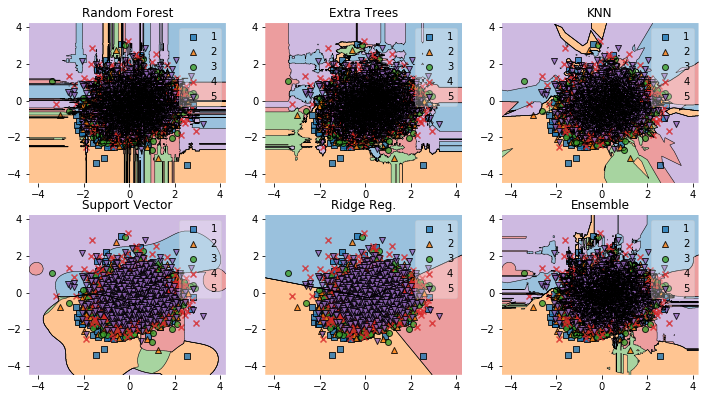

In [111]:
# Now plot the decision regions with only two features
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 10))
labels = ['Random Forest', 'Extra Trees', 'KNN', 'Support Vector',
          'Ridge Reg.', 'Ensemble']

for clf, lab, grd in zip([rf, et, knn, svc, rg, eclf], 
                         labels,
                         itertools.product([0, 1, 2], repeat = 2)):

    clf.fit(X[[1,2]], y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[[1,2]]), 
                                y=np.array(y), clf=clf)
    plt.title(lab)

In [112]:
from mlxtend.classifier import EnsembleVoteClassifier
import warnings
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

warnings.filterwarnings('ignore')

# Create boosting classifiers
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

boost_array = [ada_boost, grad_boost, xgb_boost]

eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.357, std: (+/-) 0.014 [Ada Boost]
Mean: 0.386, std: (+/-) 0.016 [Grad Boost]
Mean: 0.375, std: (+/-) 0.014 [XG Boost]
Mean: 0.381, std: (+/-) 0.016 [Ensemble]


In [113]:
X.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='object')

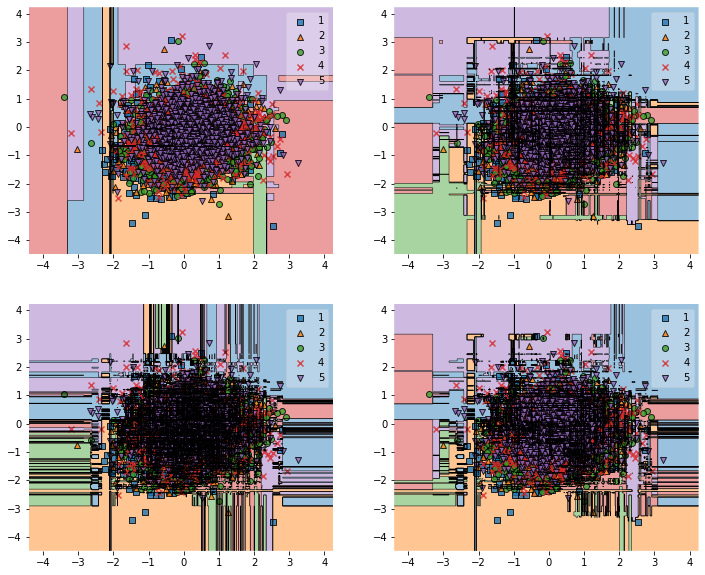

In [114]:

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(12, 10))

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, lab, grd in zip([ada_boost, grad_boost, xgb_boost, eclf],
                         labels,
                         itertools.product([0, 1], repeat = 2)):

    clf.fit(X[[1, 2]].values, y.values)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[[1, 2]].values), 
                                y=np.array(y.values), clf=clf)

In [115]:
from mlens.ensemble import SuperLearner
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr = LogisticRegression()

seed = 1075

ensemble = SuperLearner(scorer = accuracy_score, 
                        random_state=seed, 
                        folds=10,
                        verbose = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

# Build the first layer
ensemble.add([rf, et, knn, rg])
# Attach the final meta estimator
ensemble.add_meta(lr)

ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)
print("Fit data:\n%r" % ensemble.data)
print("Accuracy score: {:.3f}".format(accuracy_score(preds, y_test)))


Fitting 2 layers
Processing layer-1             done | 00:00:19
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:19

Predicting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:03
Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  extratreesclassifier         0.37     0.02  1.79  0.19  0.08  0.04
layer-1  kneighborsclassifier         0.30     0.02  0.11  0.01  0.70  0.02
layer-1  randomforestclassifier       0.37     0.02  3.87  0.05  0.03  0.01
layer-1  ridgeclassifier              0.40     0.02  0.02  0.00  0.00  0.00

Accuracy score: 0.372


In [116]:
from itertools import combinations

names = ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier']

def zip_stacked_classifiers(*args):
    to_zip = []
    for arg in args:
        combined_items = sum([list(map(list, combinations(arg, i))) for i in range(len(arg) + 1)], [])
        combined_items = filter(lambda x: len(x) > 0, combined_items)
        to_zip.append(combined_items)
    
    return zip(to_zip[0], to_zip[1])

stacked_clf_list = zip_stacked_classifiers(clf_array, names)

best_combination = [0.00, ""]

for clf in stacked_clf_list:
    
    ensemble = SuperLearner(scorer = accuracy_score, 
                            random_state = seed, 
                            folds = 10)
    ensemble.add(clf[0])
    ensemble.add_meta(lr)
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    
    if accuracy > best_combination[0]:
        best_combination[0] = accuracy
        best_combination[1] = clf[1]
    
    print("Accuracy score: {:.3f} {}".format(accuracy, clf[1]))

print("\nBest stacking model is {} with accuracy of: {:.3f}".format(best_combination[1], best_combination[0]))

Accuracy score: 0.345 ['Random Forest']
Accuracy score: 0.358 ['Extra Trees']
Accuracy score: 0.295 ['KNeighbors']
Accuracy score: 0.392 ['SVC']
Accuracy score: 0.394 ['Ridge Classifier']
Accuracy score: 0.351 ['Random Forest', 'Extra Trees']
Accuracy score: 0.346 ['Random Forest', 'KNeighbors']
Accuracy score: 0.369 ['Random Forest', 'SVC']
Accuracy score: 0.383 ['Random Forest', 'Ridge Classifier']
Accuracy score: 0.349 ['Extra Trees', 'KNeighbors']
Accuracy score: 0.379 ['Extra Trees', 'SVC']
Accuracy score: 0.385 ['Extra Trees', 'Ridge Classifier']
Accuracy score: 0.395 ['KNeighbors', 'SVC']
Accuracy score: 0.393 ['KNeighbors', 'Ridge Classifier']
Accuracy score: 0.394 ['SVC', 'Ridge Classifier']
Accuracy score: 0.370 ['Random Forest', 'Extra Trees', 'KNeighbors']
Accuracy score: 0.392 ['Random Forest', 'Extra Trees', 'SVC']
Accuracy score: 0.372 ['Random Forest', 'Extra Trees', 'Ridge Classifier']
Accuracy score: 0.375 ['Random Forest', 'KNeighbors', 'SVC']
Accuracy score: 0.380 [